# pycbf - Basic example

This notebook roughly simulates channel data and beamforms it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import ctypes as ct

## Generating channel data

In [2]:
# channel data parameters
fc = 5E6        # centerfrequency of plane wave excitation [Hz]
fs =  6 * fc    # sampling frequency [Hz]
c = 1540        # speed of sound [m/s]
lam = c/fc      # wavelength [m]

nele = 64       # number of elements in probe
dele = lam      # probe spacing [m]

# locations of elements
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele, indexing='ij')
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# reconstruction grid
xgrid = dele*(np.arange(0, nele, 1/2) - (nele-1)/2)
ygrid = 0
zgrid = np.arange(1*lam, nele*dele, lam/8)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
grid = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

## Calculate the full synthetic aperture using a point-like assumption

In [3]:
# location of point scatterer
pointa = np.array([[nele*dele/8, 0, nele*dele/4]])
pointb = np.array([[-nele*dele/7, 0, nele*dele/3]])
pointc = np.array([[0, 0, 2*nele*dele/7]])

rf = 0
for point in [pointa, pointb, pointc]:
    # time delays between each element and the point
    tau = np.linalg.norm(eles - point, axis=-1)/c

    # generate all (realtive) time points for each pulse
    tmax = 2*np.sqrt((dele * (nele-1))**2 + (nele*dele)**2)/c
    t = np.arange(0, tmax, 1/fs)

    # calculate all delay tabs
    T = t[None,None,:] - (tau[:,None,None] + tau[None,:,None])

    # make rf data from tabs
    rf += sig.gausspulse(t=T, fc=fc, bw=0.75)

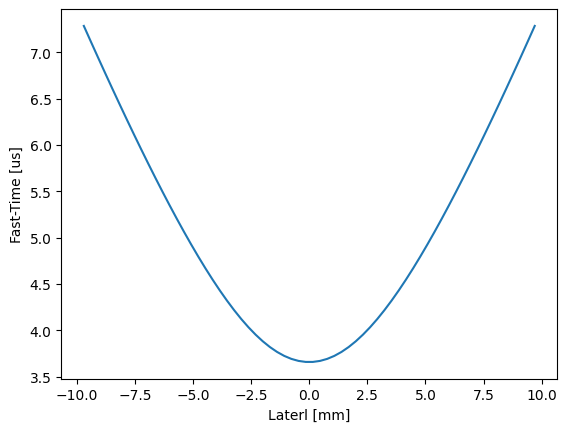

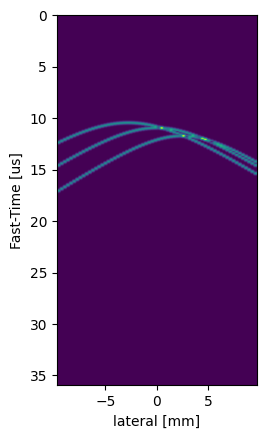

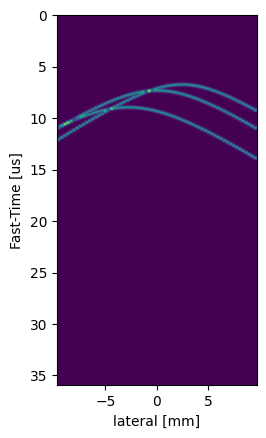

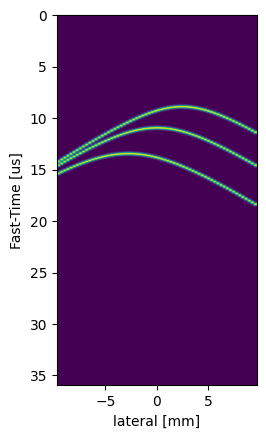

In [4]:
# plot delay tabs
plt.figure()
plt.plot(1E3*xele, 1E6*tau.flatten())
plt.xlabel("Laterl [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

env = np.abs(sig.hilbert(rf, axis=-1))
plt.figure()
plt.imshow(env[0,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[nele//2,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[-1,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

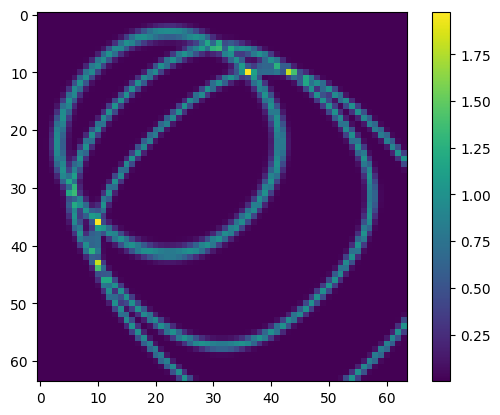

In [5]:
plt.figure()
plt.imshow(env[:,:,np.argmin(np.abs(t-10E-6))].T)
plt.colorbar()
plt.show()

In [6]:
dXvec = grid[None,:,:] - eles[:,None,:]
fnum = 1
tautxrx = np.linalg.norm(dXvec, axis=-1)/c
apodrect = np.abs(dXvec[:,:,0]) - dXvec[:,:,2]/(2*fnum) < 0

In [7]:
from tqdm.notebook import tqdm

In [16]:
from dataclasses import dataclass, field
from typing import ClassVar
from pycbf.__bf_base_classes__ import Tabbed, Parallelized, BeamformerException, __BMFRM_PARAMS__
from numpy import ndarray

@dataclass(kw_only=True)
class CPUBeamformer(Tabbed, Parallelized):
    nwrkr : int = 8
    t0 : float = field(init=True)
    dt : float = field(init=True)
    nt :   int = field(init=True)
    thresh : float = 1E-2

    def __post_init__(self):
        Parallelized.__post_init__(self)
        Tabbed.__post_init__(self)
        from multiprocessing import RawArray
        from ctypes import c_float

        __BMFRM_PARAMS__[self.id] = {}

        # Access the global shared buffer
        params = __BMFRM_PARAMS__[self.id]

        # copy tx/rx/output point dimensions
        params['ntx']    = self.ntx
        params['nrx']    = self.nrx
        params['nop']    = self.nop
        params['t0']     = self.t0
        params['dt']     = self.dt
        params['nt']     = self.nt
        params['thresh'] = self.thresh

        # the ctype being used, might eb flexible in future
        c_type = c_float

        # copy the tabs
        params['pttx'] = RawArray(c_type, self. tautx.flatten())
        params['ptrx'] = RawArray(c_type, self. taurx.flatten())
        params['patx'] = RawArray(c_type, self.apodtx.flatten())
        params['parx'] = RawArray(c_type, self.apodrx.flatten())

        # build an output buffer for each worker
        params['results'] = {}
        for ii in range(self.nwrkr):
            params['results'][ii] = RawArray(c_type, self.nop)

        # build the buffer for input RF data
        params['psig'] = RawArray(c_type, self.nt * self.ntx * self.nrx)

        self.pool = None

    @staticmethod
    def __offset_pnt__(pnt, offset:int):
        from ctypes import sizeof, cast, POINTER

        # convert to a void-type pointer object
        pvoid = cast(pnt, ct.c_void_p)

        # calculate the element offset in bytes
        pvoid.value += int(offset * sizeof(pnt._type_))

        # reform the pointer as its original type
        pnt_out = cast(pvoid, POINTER(pnt._type_))

        return pnt_out


    @staticmethod
    def __beamform_single__(id, itx, irx):
        """Use the identified beamformer to beamform the aline specified by tx and rx indices"""
        from numpy import ravel_multi_index
        from pycbf.cpu import __cpu_pycbf__

        params = __BMFRM_PARAMS__[id]

        iwrkr = params['idx']
        ntx   = params['ntx']
        nrx   = params['nrx']
        nop   = params['nop']

        t0    = params['t0']
        dt    = params['dt']
        nt    = params['nt']
        thr   = params['thresh']

        txoff = ravel_multi_index((itx,0), (ntx,nop))
        rxoff = ravel_multi_index((irx,0), (nrx,nop))
        rfoff = ravel_multi_index((itx,irx,0), (ntx,nrx,nt))

        pttx = CPUBeamformer.__offset_pnt__(params['pttx'], txoff)
        ptrx = CPUBeamformer.__offset_pnt__(params['ptrx'], rxoff)
        patx = CPUBeamformer.__offset_pnt__(params['patx'], txoff)
        parx = CPUBeamformer.__offset_pnt__(params['parx'], rxoff)
        psig = CPUBeamformer.__offset_pnt__(params['psig'], rfoff)

        out  = params['results'][iwrkr]

        __cpu_pycbf__.beamform(
            ct.c_float(t0), ct.c_float(dt), ct.c_int(nt), psig,
            ct.c_int(nop), ct.c_float(thr), pttx, patx, ptrx, parx, out
        )

    @staticmethod
    def __mp_init_workers__(id, queue):
        __BMFRM_PARAMS__[id]['idx'] = queue.get()

    def __start_pool__(self):
        """Make the multiprocessing pool"""
        from multiprocessing import Pool, Manager

        if (self.pool is not None): self.pool.close()

        # use a process-shared queue to link workers with a persistent buffer
        manager = Manager()
        idQueue = manager.Queue()
        for i in range(self.nwrkr): idQueue.put(i)

        # setup the pool
        self.pool = Pool(
            self.nwrkr, 
            initializer=self.__mp_init_workers__,
            initargs=(self.id, idQueue,)
        )

    def __kill_pool__(self):
        if hasattr(self, "pool"): self.pool.terminate()

    def __zero_buffers__(self):
        from ctypes import memset, sizeof
        params = __BMFRM_PARAMS__[self.id]
        for iwrkr in range(self.nwrkr):
            memset(params['results'][iwrkr], 0, int(self.nop*sizeof(params['results'][iwrkr]._type_)))
        
    def __call__(self, txrxt:ndarray):
        from numpy import array, sum
        from itertools import product

        # ensure input data meets data specs
        if txrxt.shape != (self.ntx, self.nrx, len(t)):
            raise BeamformerException(f"Input data must be {self.ntx} by {self.nrx} by {len(t)}")
        
        params = __BMFRM_PARAMS__[self.id]

        for ii, rf in enumerate(txrxt.flatten()): params['psig'][ii] = rf

        self.__zero_buffers__()

        # delay and apodize
        self.__start_pool__()
        self.pool.starmap(CPUBeamformer.__beamform_single__, product([self.id], range(self.ntx), range(self.nrx)))

        temp = array([params['results'][id][:self.nop] for id in range(self.nwrkr)])

        return sum(temp, axis=0)

    def __del__(self):
        self.__kill_pool__()

In [17]:
bfcpu = CPUBeamformer(
    tautx=tautxrx, 
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    nwrkr=8,
    nt = rf.shape[-1],
    t0 = t[0],
    dt = t[1]-t[0]
)

In [18]:
res = bfcpu(rf)

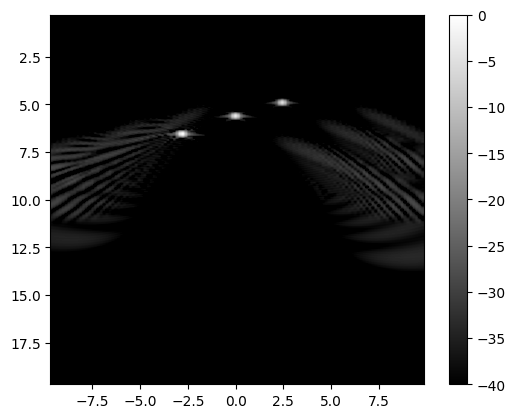

In [19]:
imrect = res.reshape(Xgrid.shape).squeeze().T
envrect = np.abs(sig.hilbert(imrect, axis=0))

logged = 20*np.log10(envrect/np.max(envrect))

ex_bmode = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, cmap='gray', extent=ex_bmode)
plt.colorbar()
plt.show()